# Tutorial 3: Post-Processing and Accuracy Assessment in *joe*

Written by Adam Morgan

*Last Updated September 24, 2024*

So far, we've seen how to use *joe* to simulate first and second order in time problems, and to produce pictures and movies summarizing these simulations. We've found that, in cases like the BBM solitary wave and the singe-Gordon kink collision, *joe* produced what we expected it to, at least at the level of visual inspection. However, inspection isn't enough to establish the accuracy of a numerical algorithm.

In this tutorial, we learn how *joe*'s modest suite of helper functions makes quantitative post-processing tasks including *a posteriori* accuracy validation elegant and easy. Even if you're *not* the kind of person who gets excited about convergence studies, some of the tools I introduce in this demo will still prove useful for various scientific post-processing tasks you may encounter.  

To spice up the topic of post-processing a little bit, let's look at a really cool problem. The **$\varphi^4$ model** is a famous toy model in high-energy theory: 

$$
\varphi_{tt} - \varphi_{xx} = \varphi - \varphi^3, \quad \varphi\colon \mathbb{R}\times\mathbb{R}\rightarrow \mathbb{R}. 
$$

Broadly speaking, this model describes the dynamics of a *real-valued version* of the Higgs field by which elementary particles acquire their mass. Additionally, like sine-Gordon, this PDE possesses kink solutions with nontrivial topological charge, but unlike sine-Gordon this kinks may interact with one another inelastically and are therefore not solitons. For more background on this model, see for instance Coleman 1985 or Manton & Sutcliffe 2004. 

Today, we concern ourselves with perturbations of a particular static kink solution. Let's denote this kink by 

$$
K_0(x) = \tanh\left(\frac{x}{\sqrt{2}}\right). 
$$

We look for solutions of the $\varphi^4$ PDE in the form 

$$
\varphi(x,t) = K_0(x) + u(x,t),
$$

where we assume $u(x,t)$ is small. A quick calculation shows that the perturbation $u(x,t)$ satisfies the variable-coefficient equation 

$$
u_{tt} + Hu_{xx} = -3K_0(x) u^2 -u^3, 
$$

where $H$ is the Schroedinger operator 

$$
H = -\partial_{x}^2 +2 -3\text{sech}^2\left(\frac{x}{\sqrt{2}}\right). 
$$

The perturbation $u(x,t)$ has a conserved energy given by 

$$
E[u] =\frac12 \int_{-\infty}^{+\infty} u_t^2+ u_x^2 +\left(2-3\text{sech}^2\left(\frac{x}{\sqrt{2}}\right)\right)u^2 + 2K_0(x)u^3 + \frac12 u^4 \ \mathrm{d}x
$$

As shown in Coleman 1985 Ch. 6 section 2.2, the spectral theory of $H$ implies that $K_0(x)$ is linearly stable. Nonlinear stability, however, is a delicate question. This is because $H$ admits *bound states* as well as *scattering states*, and when the nonlinearity is kept around these two components of the spectrum can exchange energy. Is the energy exchange enough to sap energy away from the bound state over time, eventually turning all of $u(x,0)$ into scattering radiation and guaranteeing asymptotic stability of $K_0(x)$?  

The question of asymptotic kink stability has been addressed with physical, numerical, and analytical approaches: a smattering of the relevant literature is provided below (this bibliography is **absolutely not comprehensive!**). The general consensus is that, provided the initial perturbation $u(x,0)$ is *odd*, the bound state component of $u(x,t)$ radiates energy away over time so its amplitude decays like $t^{-\frac12}$, but more work is needed to get 100% rigorous, relatively sharp global-in-time decay estimates.

Since this problem is interesting enough to be a topic of recent research but well-understood enough to know what sort of answer to expect, predicting the bound state decay rate is an ideal problem for a new software like *joe*! 

However, before using *joe* to address asymptotic stability, we should address the following questions. 

1) Does *joe* conserve the energy $E[u]$ to high accuracy? This is required to ensure that any amplitude loss we see in the bound state is due to bound-state-to-scattering-state energy exchanges rather than numerical error.

2) Does *joe* actually achieve the fourth-order-in-$\Delta t$ accuracy we are implicitly claiming when we use ETDRK4? This is required to make sure we trust any radiation appearing in the simulations: without high accuracy, we can't distinguish between physical radiation and errors.

In this tutorial, we'll address the two questions above in order to pave the wave for addressing kink stability with *joe* later on (full details of the stability experiments will appear in a preprint coming in the near future). 

### Recommendations for Further Reading 

#### Physics of the $\varphi^4$ Model
- Coleman, *Aspects of Symmetry*, Cambrdige Univ. Press, 1985. https://www.cambridge.org/core/books/aspects-of-symmetry/7791D1FCFD0FA0CD1CC54C961E2DF470

- Manton and Sutcliffe, *Topological Solitons*. Cambridge Univ. Press, 2004. https://www.cambridge.org/core/books/topological-solitons/0A9670253EB1C8254BDACA4EE30C3AA3

#### $\varphi^4$ Kink Stability
- Barashenkov and Oxtoby, Phys. Rev. E, 2009. https://journals.aps.org/pre/abstract/10.1103/PhysRevE.80.026608

- Delort and Masmoudi, *Long-Time Dispersive Estimates for Perturbations of a Kink Solution of One-Dimensional Cubic Wave Equations*. EMS, 2022. https://ems.press/books/mems/233 

- Kowalczyk et al., Journal of the AMS, 2017. https://www.ams.org/journals/jams/2017-30-03/S0894-0347-2016-00870-6/

- Manton and Merabet, Nonlinearity, 1997. https://iopscience.iop.org/article/10.1088/0951-7715/10/1/002

## Prelude: Numerical Integration on a Periodic Grid

To assess energy conservation for $\varphi^4$ perturbations or any other PDE, we need to compute spatial integrals of our solution and its derivatives. So, before diving into the $\varphi^4$ model, I'll discuss how *joe* computes spatial integrals.   

Let's start by considering the function 

$$ f(x) = \sin(2x) $$

defined for $x\in [-\pi, \pi]$. We want to compute 

$$ I = \int_{-\pi}^{\pi} f(x) \ \mathrm{d} x  $$

numerically. Of course, we know that $I=0$, but we want to test different methods out. 

**Method 1**: use the trapezoidal rule (which should converge nicely because our function is periodic!).

**Method 2**: take the FFT of $f(x)$, then extract the zeroth frequency.

In [1]:
import numpy as np 
from scipy.fftpack import fft
from scipy.integrate import trapezoid

In [2]:
# first make a grid
N = 2**5
x = np.linspace(-np.pi, np.pi, num=N, endpoint=False)

# sample fnc on the grid
y = np.sin(2.*x)

# method 1: trapezoidal rule
I1 = trapezoid(y,dx=2.*np.pi/N)

# method 2: fft
I2 = (2.*np.pi/N)*np.real(fft(y)[0]) # we could really use rfft but speed is not concerning here

In [3]:
print(I1)
print(I2)

0.037569858117771596
-3.910494510717105e-17


Method 2 achieves machine precision while Method 1 has but one digit of accuracy! This suggests that we ought to use the FFT for our numerical computations of energy and other functionals. Indeed, the helper function $\texttt{integrate}$ from $\texttt{joe\_lab.utils}$ does precisely this!

*Note: $\texttt{integrate}$ was used under the hood in tutorial 1 to check mass conservation for BBM!*

## Accuracy Assessment for $\varphi^4$ Perturbation

In [4]:
from scipy.fft import rfft, irfft, rfftfreq

import joe_lab.joe as joe
import joe_lab.models as joe_models
import joe_lab.initial_states as joe_initial_states
from joe_lab.visualization import nice_plot
from joe_lab.utils import integrate

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%matplotlib inline
%config InlineBackend.figure_format='retina'

import os

# add the folder "joe_visuals" to our path
my_path = os.path.join("joe_visuals")

# first, if the folder doesn't exist, make it
if not os.path.isdir(my_path):
    os.makedirs(my_path)

# make sure Image and Video can be displayed in the notebook. 
from IPython.display import Image, Video

We'll simulate the $\varphi^4$ perturbation equation 

$$
u_{tt} + Hu_{xx} = -3K_0(x) u^2 -u^3
$$

subject to the *odd* initial conditions

$$
u|_{t=0} = \epsilon \sin\left(x\right) e^{-x^2}, \quad u_{t}|_{t=0}=0. 
$$

with $\epsilon=0.1$. We use a periodic grid $[-120, 120]$ and simulate up to time $T=100$ to ensure radiation from the initial state doesn't reach the boundary: even though we are interested in eventually simulating very long times and therefore require a sponge layer, we can only test energy conservation sensibly without artifical damping near the boundary. 

By now, you're an expert in defining models, initial states, and simulations, and the code box below will make sense (up to a naming convention for the initial state from the built-ins):

In [5]:
# first prescribe all the simulation parameters etc.
length, T, N, dt = 240.,100., 2**9, 1e-2

stgrid = {'length': length, 'T': T, 'N': N, 'dt': dt}
my_model = joe_models.builtin_model('phi4pert', nonlinear=True)
my_initial_state = joe_initial_states.builtin_initial_state('gaussian_odd')

# obtain the relevant simulation, either by loading it up again or by running it.
my_sim = joe.simulation(stgrid, my_model, my_initial_state, bc='periodic', ndump=20)
my_sim.load_or_run(method_kw='etdrk4', print_runtime=True, save=True)

No saved simulation found, running simulation.
Simulation runtime = 5.280 s


A small remark particular to this problem: even though the potential term in the Schroedinger operator $H$ still acts linearly on $u$, because it varies with $x$ it must be treated like part of the nonlinearity when it's being handled in *joe*. That is, if $\texttt{V0}$ is the potential and $\texttt{K0}$ is the kink, the spatial forcing looks like 

$$
\texttt{spatial\_forcing = - V0(x) * u - (3. * K0(x) * u ** 2 + u ** 3)}
$$

under the hood. 

Before investigating energy conservation, we can quickly throw up a Hovmoeller plot to see if the output makes sense. 

Rendering Hovmoeller plot... |████████████████████████████████████████| in 0.8s 


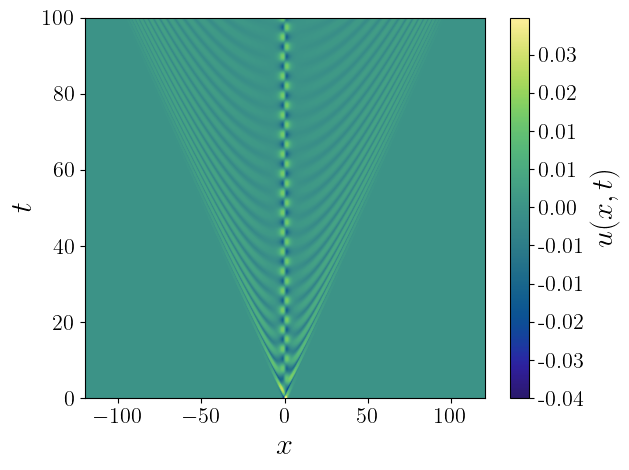

In [6]:
my_sim.hov_plot(cmap='cmo.haline', fieldname='u', show_figure=False, save_figure=True, usetex=True)

Image('joe_visuals/' + my_sim.picname, embed=True)

We clearly see the solution consists of a bound-state component that stays localized near $x=0$ and radiating components that are moving towards $\pm\infty$. 

Now we assess energy conservation in our post-processing stage. Our first task is to define a function that computes the energy of our state at any time $t$ we stored.

In [7]:
x = my_sim.x
Udata = my_sim.Udata

# need these for energy, and they're built-in to make the nonlinear term for phi^4 perturbations
from joe_lab.models import K0, V0

# K0 = kink, V0 = potential in Schro. operator

def energy(u, ut):
    kin = ut ** 2

    # get wavenumbers for the grid of S^1 with N samples
    k = 2. * np.pi * N * rfftfreq(N) / length

    spring = irfft(1j * k * rfft(u)) ** 2

    potential = (2. + V0(x)) * (u ** 2) + 1.*(2. * K0(x) * u ** 3 + 0.5 * u ** 4)

    e_dens = kin + spring + potential

    out = 0.5*integrate(e_dens, length)

    return out

Note the use of the helper function $\texttt{integrate}$! This integrates along the $-1^{\text{th}}$ axis of the numpy array, which corresponds to the spatial dimension using *joe*'s storage conventions. From here, it's easy to get the energies associate to each time. 

In [8]:
# get the energies associated to each time
times = np.linspace(0., T, num=1 + int(T / (dt*my_sim.ndump)), endpoint=True)
E = energy(Udata[0, :, :],  Udata[1, :, :])

I remark that $\texttt{integrate}$ and, consequently, $\texttt{energy}$ are vectorized so we can call them without nasty loops. 

We can also use the helper function $\texttt{nice\_plot}$ (which just wraps $\texttt{plt.plot}$ with all the setting just the way I like them) included with *joe* to plot the relative error in the energy during our simulation. 

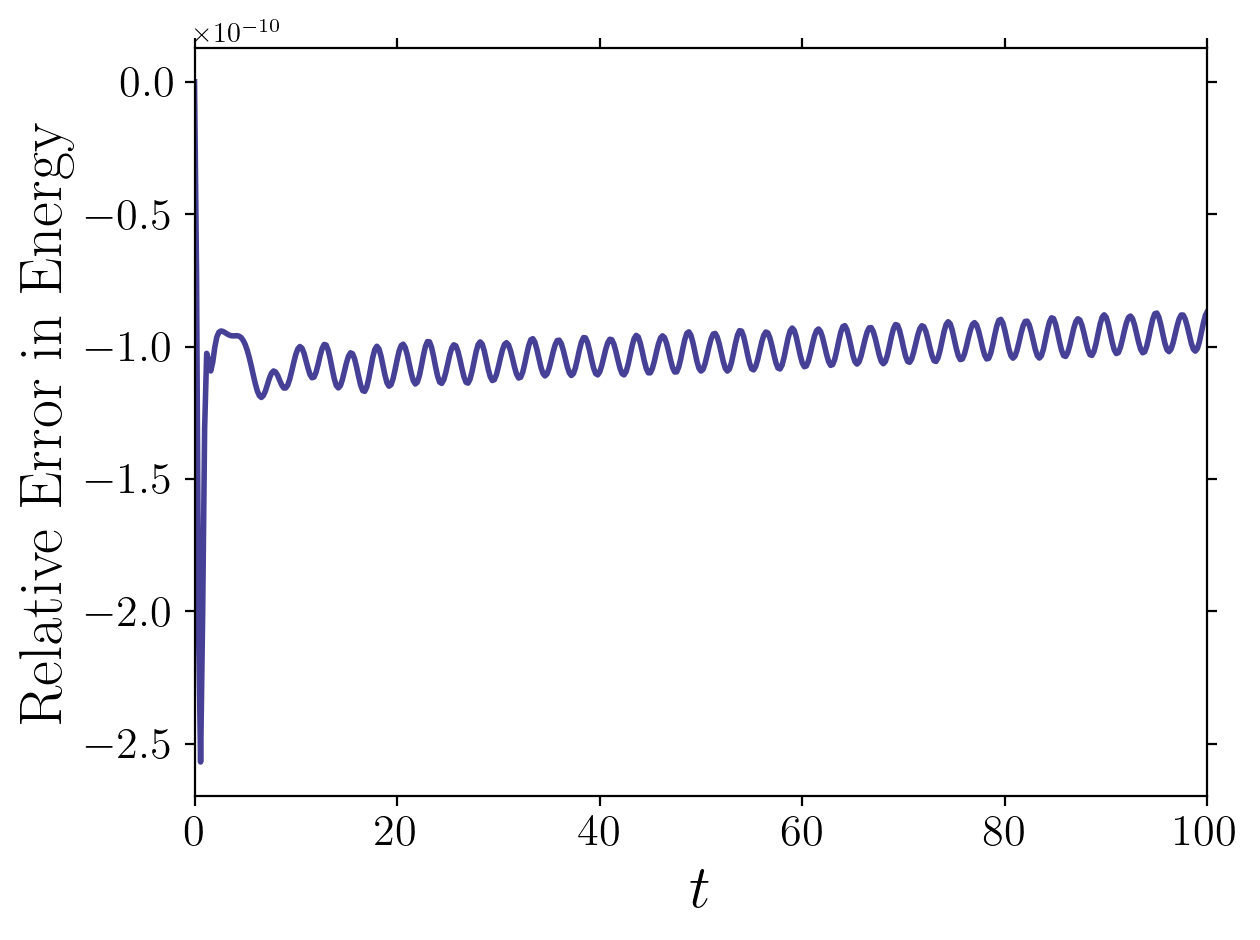

In [9]:
dpi = 400
picname = 'phi4pert_energy_test_length=%.1f_T=%.1f_N=%.1f_dt=%.6f' % (length, T, N, dt) + '_ICkw=' + my_sim.initial_state_kw  + '.png'
nice_plot(times, (E-E[0])/E[0], r'$t$', r'Relative Error in Energy', dpi=dpi, show_figure=True,
          save_figure=True, picname=picname, linestyle='solid', color='xkcd:blueberry', usetex=True)

We conclude that *joe* conserves the energy of $u$ exceptionally well. In particular, the relative error in energy is not monotone in $t$, which bodes well for long-time simulations: on average over time, energy is not created or destroyed by the time-stepper, at least to high precision. 

Next, we need to perform a refinement study to check that *joe* is achieving fourth-order accuracy (in $\Delta t$) on our problem. For this purpose, we can use perform a sequence of simulations on varying space-time grids and use Richardson extrapolation to estimate the error in each of these simulations. We must also estimate the slope of the $\Delta t$ vs. error curve on a loglog plot and verify quartic convergence.

Given a sequence of grid sizes $\texttt{Ns}$ and a sequence of time steps $\texttt{dts}$, *joe* can take care of this tedious but important task with a few lines of code. 

**WARNING**: this code takes about 5 minutes to run on my desktop (it's doing a lot of simulations on some very fine grids!) 

In [10]:
# perform Richardson accuracy test
nmin, nmax = 4, 9
Ns = np.array([2**7, 2**8, 2**9, 2**10])
dts = np.flip(np.logspace(-nmax, -nmin, num=nmax-nmin+1, base=2.))

joe.do_refinement_study(my_model, my_initial_state, length, T, Ns, dts, bc='periodic', method_kw='etdrk4',
                    show_figure=False, save_figure=True, usetex=True, dpi=dpi, fit_min=0, fit_max=4)

Performing refinement study... |████████████████████████████████████████| in 15.


KeyboardInterrupt: 

In [ ]:
refinement_picname = 'refinement_study_length=240.0_T=100.0_modelkw=phi4pert_ICkw=gaussian_odd_method_kw=etdrk4_nonlinear=True_abslayer=False'
Image('joe_visuals/' + refinement_picname + '.png', embed=True)

The parameters $\texttt{fit\_min}, \texttt{fit\_max}$ tell the code what entries of $\texttt{dts}$ to use in computing the slope of the best-fit line on the error curve corresponding to the largest $N$-value: since $\Delta t$ needs to be small enough for convergence to start happening but not so small that roundoff errors begin to dominate the simulation, these may need to be changed on-the-fly depending on the problem at hand.  

From this picture and the subsequent slope estimate, the fourth-order convergence of our scheme is confirmed! All in all, we can be confident that *joe* is a solid tool for computationally confirming existing long-time results on the kink stability problem. 